In [44]:
import sys 
sys.path.append('../')

In [68]:
import os
import torch
from PIL import Image
import pandas as pd 
import sys 
import json 
from src import dataset_lvis
from src import metrics
from src import helper_functions as helper
import importlib
from pathlib import Path 
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt

In [69]:
importlib.reload(dataset_lvis)

<module 'src.dataset_lvis' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/dataset_lvis.py'>

In [70]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

pick an easier problem:
<br> sofa	414	528	f
<br> signboard	398	1799	


https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

In [71]:
data_args = {'stage': 'val',
            'classes': ['airplane','sofa'], #, 'signboard'],
            'ds_path' : "/home/Datasets/coco/",
            'labels_dir': "annotations",
            'images_dir': 'images',
             'height' : 480,
             'width' : 640 }
val_data = dataset_lvis.LVISData(**data_args)

Loaded 180 images!
245 annotations found!
classes : {1: 'airplane', 2: 'sofa'}
stage:  val
ds_path:  /home/Datasets/coco/
labels_f:  /home/Datasets/coco/annotations/lvis_v1_val.json
imgs_dir:  /home/Datasets/coco/images/val2017


# Fine-tuning the model

In [72]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [75]:
#Split dataset to test and train
indices = torch.randperm(len(val_data)).tolist()


dataset_train = torch.utils.data.Subset(val_data, indices[:150])
dataset_test = torch.utils.data.Subset(val_data, indices[150:])


train_loader = torch.utils.data.DataLoader(
 dataset_train, batch_size=5, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())


test_loader = torch.utils.data.DataLoader(
 dataset_test, batch_size=1, shuffle=True, #num_workers=4,
 collate_fn=helper.CollateCustom())



In [62]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [74]:
importlib.reload(helper)

<module 'src.helper_functions' from '/home/INM705/INM705_CW_Collins_Velagala/notebooks/../src/helper_functions.py'>

In [64]:
# let's train it for 10 epochs
from torch.optim.lr_scheduler import StepLR
import pandas as pd 
import time 


num_epochs = 10
time_start = time.time() 


loss_df = pd.DataFrame(columns = ['epoch', 'loss_classifier', 'loss_box_reg', 'loss_mask', 'loss_objectness', 'loss_rpn_box_reg', 'total_loss'])
#batch_loss = 0 


for epoch in range(num_epochs):
    model.train()
    
    #reset loss 
    batch_loss = 0
    loss_classifier = 0
    loss_box_reg = 0
    loss_mask = 0
    loss_objectness = 0
    loss_rpn_box_reg = 0
    
    
    
    for batch_num, (idx, X, y) in enumerate(train_loader):
        #print(idx)
        X = X.to(device)
        y = [{k: v.to(device) for k, v in t.items()} for t in y]
        
        loss_dict = model(X, y) 
        
        #save losses 
        loss_classifier += loss_dict['loss_classifier'].item()
        loss_box_reg += loss_dict['loss_box_reg'].item()
        loss_mask += loss_dict['loss_mask'].item()
        loss_objectness += loss_dict['loss_objectness'].item()
        loss_rpn_box_reg += loss_dict['loss_rpn_box_reg'].item() 
        
        losses = sum(loss for loss in loss_dict.values())
        batch_loss  += losses.item()
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
    avg_batch_loss = batch_loss/(batch_num + 1) 
    
    row = pd.DataFrame({'epoch': [epoch],
          'loss_classifier': [loss_classifier/(batch_num+1)],
          'loss_box_reg' : [loss_box_reg/(batch_num+1)],
           'loss_mask': [loss_mask/(batch_num+1)],
           'loss_objectness': [loss_objectness/(batch_num+1)],
           'loss_rpn_box_reg': [loss_rpn_box_reg/(batch_num+1)],
            'total_loss': avg_batch_loss 
          })     

    loss_df = pd.concat([loss_df, row], ignore_index = True, axis = 0)
    
    #save checkpoint every 5 epoch? 
    if epoch%5 == 0: 
        checkpoint = {"state_dict": model.state_dict(),
                        "optimizer": optimizer.state_dict(),
                        "step": epoch
                        }
        fname = "model_" + str(epoch) + "_epochs.pth"
        #UNCOMMENT THIS 
        helper.save_checkpoint(checkpoint, fname)
    

    print(f"Loss after {epoch} epochs: {avg_batch_loss}")
    
    #for final epoch 
    if epoch == num_epochs-1: 
        helper.save_model(model.state_dict(), "model.pth")
    
    
    
print(f"Time elapsed for {epoch+1} epochs: {round((time.time()-time_start)/60, 2)} min")

Saved checkpoint model_0_epochs.pth!
Loss after 0 epochs: 1.064190290371577
Loss after 1 epochs: 0.5701790034770966
Loss after 2 epochs: 0.46148761808872224
Loss after 3 epochs: 0.3512116879224777
Loss after 4 epochs: 0.2845169633626938
Saved checkpoint model_5_epochs.pth!
Loss after 5 epochs: 0.23742074221372605
Loss after 6 epochs: 0.21134539544582367
Loss after 7 epochs: 0.19808619618415832
Loss after 8 epochs: 0.1853336160381635
Loss after 9 epochs: 0.1768906613190969
Saved model model.pth!
Time elapsed for 10 epochs: 3.89 min


In [65]:
loss_df

,epoch,loss_classifier,loss_box_reg,loss_mask,loss_objectness,loss_rpn_box_reg,total_loss
0,0,0.187868,0.143087,0.698158,0.020316,0.014761,1.06419
1,1,0.090352,0.147034,0.312222,0.009805,0.010766,0.570179
2,2,0.06542,0.154405,0.227019,0.005936,0.008708,0.461488
3,3,0.043966,0.107006,0.188087,0.003691,0.00846,0.351212
4,4,0.037139,0.076929,0.159731,0.002759,0.007959,0.284517
5,5,0.02877,0.060916,0.140334,0.002,0.005401,0.237421
6,6,0.026052,0.047408,0.131668,0.001775,0.004444,0.211345
7,7,0.022903,0.042068,0.12671,0.001536,0.00487,0.198086
8,8,0.022048,0.03619,0.121723,0.00142,0.003951,0.185334
9,9,0.019845,0.032718,0.119476,0.001355,0.003496,0.176891


# Plot loss 

<AxesSubplot:xlabel='epoch', ylabel='total_loss'>

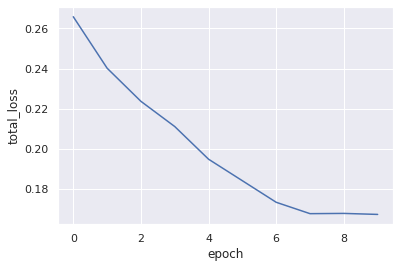

In [43]:
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set()

sns.lineplot(data=loss_df, x="epoch", y="total_loss")


# Test cases

127


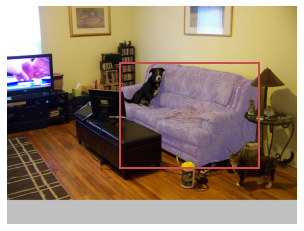

In [66]:
idx, X, y = next(iter(test_loader))
model.eval() 
None

print(idx[0])

#val_data.plot_img(idx[0])
val_data.plot_img_with_ann(idx[0], bboxes = True)

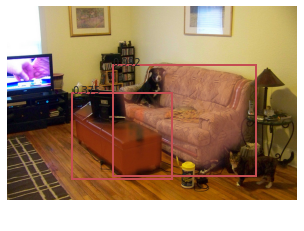

In [67]:
y_pred = model(X.to(device))
val_data.plot_predictions(idx[0], y_pred)

In [258]:
gts = y[0]['boxes']#[0]
preds = y_pred[0]['boxes'].to('cpu').detach()#[0]

for i in range(len(gt)):
    gt = gts[i]   
    IOU = metrics.get_iou(preds, gt)
    print(IOU)

tensor([[0.0663],
        [0.9067],
        [0.1696],
        [0.3370],
        [0.3835],
        [0.0000],
        [0.0000],
        [0.1322]])
tensor([[0.8522],
        [0.0616],
        [0.3446],
        [0.1692],
        [0.0258],
        [0.0868],
        [0.4331],
        [0.4572]])


In [251]:
preds.shape

torch.Size([8, 4])

In [252]:


#get corners of predictions 
pred_x1 = preds[..., 0:1] 
pred_y1 = preds[..., 1:2]
pred_x2 = preds[..., 2:3]
pred_y2 = preds[..., 3:4]

#get corner of GT 
gt_x1 = gt[..., 0:1]
gt_y1 = gt[..., 1:2]
gt_x2 = gt[..., 2:3]
gt_y2 = gt[..., 3:4]

#print(pred_x1)
print(gt_x1.shape)

#get corners of intersection 
x1 = torch.max(pred_x1, gt_x1)
y1 = torch.max(pred_y1, gt_y1)
x2 = torch.min(pred_x2, gt_x2)
y2 = torch.min(pred_y2, gt_y2)

#print(x1)

intersection = (x2-x1).clamp(0) * (y2-y1).clamp(0) 
pred_box_areas = abs((pred_x2-pred_x1) * (pred_y2-pred_y1))
gt_box_areas = abs((gt_x2-gt_x1) * (gt_y2-gt_y1))
union = pred_box_areas + gt_box_areas - intersection + 1e-6 #avoid divide by 0 

print(intersection/union)



torch.Size([2, 1])


RuntimeError: The size of tensor a (8) must match the size of tensor b (2) at non-singleton dimension 0

In [254]:
from src import metrics

In [250]:
gt[0:1].shape

torch.Size([1])

In [212]:
preds[..., 0:1]

tensor([[ 23.0702],
        [274.5056],
        [  2.8543],
        [ 85.2058]])

In [210]:
torch.max(gt[0], preds[:, 0])

tensor([ 23.0702, 274.5056, 640.0000, 415.1300])

In [126]:
masks = y_pred[0]['masks'].to('cpu').detach().numpy()
masks.shape
for mask in maks 

(5, 1, 480, 640)

In [131]:
y_pred[0]['masks'][2, :, :, :].shape

torch.Size([1, 480, 640])

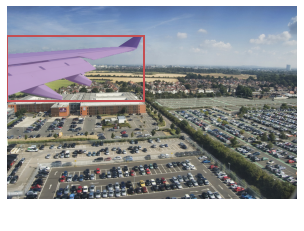

In [114]:
val_data.plot_predictions(idx[0], y)

In [88]:
masks = y[0]['masks'].to('cpu').detach().numpy()
len(masks)


2

In [192]:
scores = y_pred[0]['scores'].to('cpu').detach().numpy()
round(scores[3],3)

0.075

In [110]:
y_pred[0]['scores']

tensor([0.9879, 0.5249, 0.4059, 0.3417, 0.0594], device='cuda:0',
       grad_fn=<IndexBackward>)

NameError: name 'predictions' is not defined

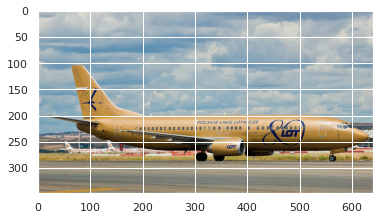

In [76]:
img_id = val_data.idx_img_map[idx[0]]
fname = str(img_id).zfill(12) + '.jpg'
path = val_data.imgs_dir + '/' + fname
im = PILImage.open(path)
#print(im.size)
show_bboxes = True

#Plots image 
plt.imshow(im)


if show_bboxes:
    bboxes = predictions['boxes'].to('cpu').detach().numpy()
    if len(bboxes) > 0:
        ax = plt.gca()        
        ax.axis('off')
        for id, b in enumerate(bboxes):
            #b = b[0] #get tuple
            rect = Rectangle((b[0],b[1]), b[2]-b[0], b[3]-b[1], linewidth=2, edgecolor='r', facecolor='none')
            ax.add_patch(rect)

if show_masks:
    masks = predictions['masks'].to('cpu').detach().numpy()
    if len(masks) > 0:
        for m in masks:
            m = m[0, :, :]
            img = np.ones( (m.shape[0], m.shape[1], 3) )
            color_mask = np.random.random((1,3)).tolist()[0]
            for i in range(3):
                img[:,:,i] = color_mask[i]
            ax.imshow(np.dstack((img, m*0.5)))

plt.show()